# Problem 1
Develop a multi-layer perceptron with two hidden layers (you pick the dimensions of the hidden layers) for Fashionmnst dataset.

1.a. train the model from scratch (with randomized parameters) and plot the results (training loss and accuracy, validation accuracy) after 20 epochs. Does your network need more epochs for full training? Do you observe overfitting? Make sure to save the trained parameters and model.  (10pts)

1.b Report section a; this time add weight penalties (weight decays). Report and plot your training results. how do the training results change compared to the baseline? (15pts)

1.c Report section a; this time add dropout (dropout = 0.3). Report and plot your training results. how do the training results change compared to the baseline? How the training results change compared to the weight penalties. (15pts)

1.d. repeat problems 1.b and 1.c; this time, load the pre-trained parameters from the storage. Plot the training results, and compare the training time and number of epochs needed against 1.b and 1.c. (20pts)

In [ ]:
!pip install torchmetrics
!pip install d2l==1.0.0b0

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, Subset

from torchvision import transforms, datasets
from torchmetrics.classification import MulticlassAccuracy, BinaryAccuracy
from torchmetrics import ConfusionMatrix

from d2l import torch as d2l

In [3]:
def cpu():  #@save
    return torch.device('cpu')
def gpu(i=0):  #@save
    return torch.device(f'cuda:{i}')
cpu(), gpu(), gpu(1)

(device(type='cpu'),
 device(type='cuda', index=0),
 device(type='cuda', index=1))

In [4]:
def num_gpus():  #@save
    return torch.cuda.device_count()
num_gpus()

1

In [5]:
def try_gpu(i=0):  #@save
    """Return gpu(i) if exists, otherwise return cpu()."""
    if num_gpus() >= i + 1:
        return gpu(i)
    return cpu()

In [6]:
d2l.use_svg_display()

In [7]:
class FashionMNIST(d2l.DataModule):  #@save
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True)

In [8]:
data = FashionMNIST(resize=(32, 32))
len(data.train), len(data.val)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



(60000, 10000)

In [19]:
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))

In [20]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [21]:
@d2l.add_to_class(MLPScratch)
def forward(self, X):
    X = X.reshape((-1, self.num_inputs))
    H = relu(torch.matmul(X, self.W1) + self.b1)
    return torch.matmul(H, self.W2) + self.b2

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-25-30c732ea413e>", line 4, in <module>
    trainer.fit(model, data)
  File "/usr/local/lib/python3.8/dist-packages/d2l/torch.py", line 274, in fit
    self.fit_epoch()
  File "/usr/local/lib/python3.8/dist-packages/d2l/torch.py", line 286, in fit_epoch
    for batch in self.train_dataloader:
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 628, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1316, in _next_data
    idx, data = self._get_data()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1282, in _get_data
    success, data = self._try_get_data()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.p

KeyboardInterrupt: ignored

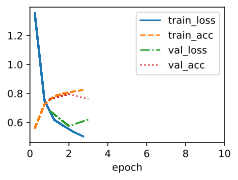

In [25]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [26]:
# class MLPScratch(d2l.Classifier):
#     def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
#         super().__init__()
#         self.save_hyperparameters()
#         self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
#         self.b1 = nn.Parameter(torch.zeros(num_hiddens))
#         self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
#         self.b2 = nn.Parameter(torch.zeros(num_outputs))
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))

In [27]:
@d2l.add_to_class(d2l.Classifier)
def training_step(self, batch):
  l = self.loss(self(*batch[:-1]), batch[-1])
  Y_hat = self(*batch[:-1])
  self.plot('loss', l, train=True)
  self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=True)
  return l

In [29]:
@d2l.add_to_class(d2l.Classifier)
def validation_step(self, batch):
  Y_hat = self(*batch[:-1])
  # self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
  self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)

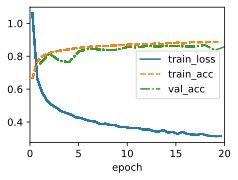

In [30]:
# model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
# model.cuda()
# data
# trainer = d2l.Trainer(max_epochs=10)
# trainer.fit(model, data)
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer = d2l.Trainer(max_epochs=20)
trainer.fit(model, data)

1a. Based on the plot, there could have been more epochs used since the training loss was still decreasing at a consistent rate. Surprisingly, there doesn't seem to be overfitting in this initial training. There were some points where the generalization gap increased, but it ended up very close to each other.